In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Section 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [140]:
# Section 2: Load Data
file_path = '/content/drive/My Drive/data/car.data'
df = pd.read_csv(file_path, header=None)

# Display summary statistics of the dataset before encoding
#print("\nSummary Statistics (before encoding):")
#print(df.describe(include='all'))

for feature in df.columns:
    print(feature)

0
1
2
3
4
5
6


In [118]:
# Section 3: Display Unique Values for Each Column
for col in df.columns:
    print(col, np.unique(df[col]))


0 ['high' 'low' 'med' 'vhigh']
1 ['high' 'low' 'med' 'vhigh']
2 ['2' '3' '4' '5more']
3 ['2' '4' 'more']
4 ['big' 'med' 'small']
5 ['high' 'low' 'med']
6 ['acc' 'good' 'unacc' 'vgood']


Data Cleaning Summary:
Column: 0
Summary: {'encoding': 'LabelEncoder', 'classes': ['high', 'low', 'med', 'vhigh']}
Column: 1
Summary: {'encoding': 'LabelEncoder', 'classes': ['high', 'low', 'med', 'vhigh']}
Column: 2
Summary: {'encoding': 'LabelEncoder', 'classes': ['2', '3', '4', '5more']}
Column: 3
Summary: {'encoding': 'LabelEncoder', 'classes': ['2', '4', 'more']}
Column: 4
Summary: {'encoding': 'LabelEncoder', 'classes': ['big', 'med', 'small']}
Column: 5
Summary: {'encoding': 'LabelEncoder', 'classes': ['high', 'low', 'med']}
Column: 6
Summary: {'encoding': 'LabelEncoder', 'classes': ['acc', 'good', 'unacc', 'vgood']}


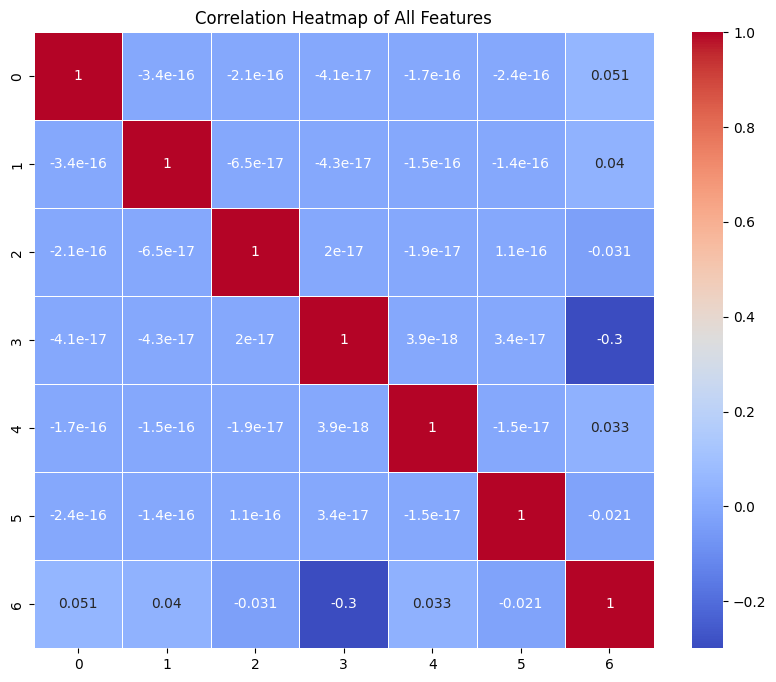

In [150]:
# Section 4: Preprocess Data
# Data Cleaning Summary
data_cleaning_summary = {}

# Convert categorical variables to numerical using LabelEncoder
label_encoder = LabelEncoder()
for col in df.columns:
    df[col] = label_encoder.fit_transform(df[col])
    data_cleaning_summary[col] = {'encoding': 'LabelEncoder', 'classes': list(label_encoder.classes_)}

# Display Data Cleaning Summary
print("Data Cleaning Summary:")
for col, summary in data_cleaning_summary.items():
    print(f"Column: {col}")
    print(f"Summary: {summary}")

# Calculate correlation matrix for all features
correlation_matrix_all = df.corr()

# Plot correlation heatmap for all features
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.show()


In [151]:
# Section 5: Split Data into Features and Target
X = df.drop(columns=[6])
y = df[6]

In [152]:
# Section 6: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [153]:
# Section 7: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [154]:
# Section 8: Calculate VIF to Remove Multicollinearity
def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X[:, variables], ix) for ix in range(X[:, variables].shape[1])]
        max_vif = max(vif)
        if max_vif > thresh:
            maxloc = vif.index(max_vif)
            print(f"Dropping feature index {maxloc} with VIF={max_vif}")
            del variables[maxloc]
            dropped = True
    print(f'Remaining variables: {variables}')
    return X[:, variables], variables

X_train_no_multicollinearity, remaining_features = calculate_vif(X_train_scaled)
X_test_no_multicollinearity = X_test_scaled[:, remaining_features]


Remaining variables: [0, 1, 2, 3, 4, 5]


In [155]:
# Section 9: Hyperparameter Tuning
param_grid = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]},
    'Extra Trees': {'n_estimators': [50, 100, 200]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5, 1]}
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),  # Needed for AUC-ROC
    "Extra Trees": ExtraTreesClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

best_estimators = {}
for name, model in models.items():
    clf = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5)
    clf.fit(X_train_no_multicollinearity, y_train)
    best_estimators[name] = clf.best_estimator_


In [156]:
# Section 10: Feature Engineering
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_no_multicollinearity)
X_test_poly = poly.transform(X_test_no_multicollinearity)

In [157]:
# Section 11: Model Selection
best_estimators['Voting Classifier'] = VotingClassifier(
    estimators=[(name, model) for name, model in best_estimators.items()],
    voting='soft'
)

In [158]:
# Section 12: Feature Scaling after Polynomial Features
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [159]:
# Section 13: Feature Selection
skb = SelectKBest(k=10)
X_train_skb = skb.fit_transform(X_train_scaled, y_train)
X_test_skb = skb.transform(X_test_scaled)

sfm = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train_sfm = sfm.fit_transform(X_train_scaled, y_train)
X_test_sfm = sfm.transform(X_test_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [160]:
# Section 14: Model Evaluation Metrics
metrics_no_average = {'Accuracy': accuracy_score}
metrics_with_average = {'Precision': precision_score, 'Recall': recall_score, 'F1 Score': f1_score}

# Collect results
results = []
classification_reports = {}

In [161]:
# Section 15: Ensemble Techniques
# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
best_estimators['AdaBoost Classifier'] = adaboost_classifier

# Bagging Classifier
bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
best_estimators['Bagging Classifier'] = bagging_classifier

# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[(name, model) for name, model in best_estimators.items()],
    final_estimator=LogisticRegression(max_iter=10000),
    cv=5,  # Cross-validation folds for base models
    stack_method='auto',  # Method to use for stacking
    n_jobs=-1  # Use all available CPU cores
)
best_estimators['Stacking Classifier'] = stacking_classifier


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Model: Logistic Regression
Accuracy: 0.8265895953757225
Precision: 0.7526516892298325
Recall: 0.8265895953757225
F1 Score: 0.7869340450230761

Classification Report:
              precision    recall  f1-score    support
0              0.645570  0.614458  0.629630   83.00000
1              0.000000  0.000000  0.000000   11.00000
2              0.880150  1.000000  0.936255  235.00000
3              0.000000  0.000000  0.000000   17.00000
accuracy       0.826590  0.826590  0.826590    0.82659
macro avg      0.381430  0.403614  0.391471  346.00000
weighted avg   0.752652  0.826590  0.786934  346.00000




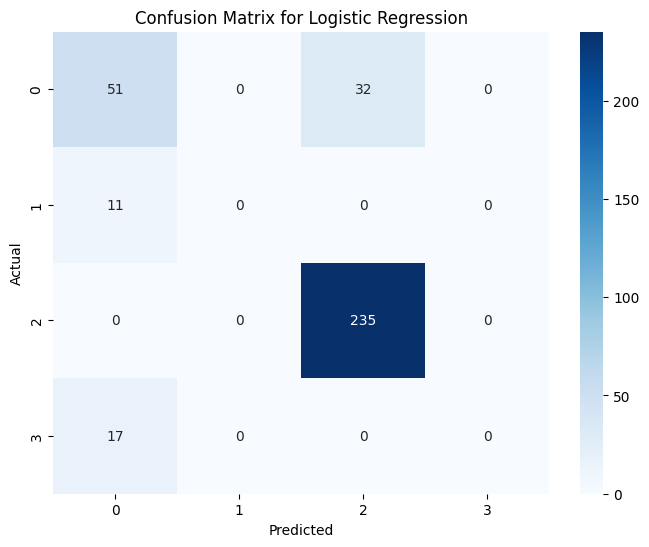

Model: Random Forest
Accuracy: 0.976878612716763
Precision: 0.9827860181186041
Recall: 0.976878612716763
F1 Score: 0.978262332944598

Classification Report:
              precision    recall  f1-score     support
0              0.987013  0.915663  0.950000   83.000000
1              0.647059  1.000000  0.785714   11.000000
2              0.995763  1.000000  0.997877  235.000000
3              1.000000  0.941176  0.969697   17.000000
accuracy       0.976879  0.976879  0.976879    0.976879
macro avg      0.907459  0.964210  0.925822  346.000000
weighted avg   0.982786  0.976879  0.978262  346.000000




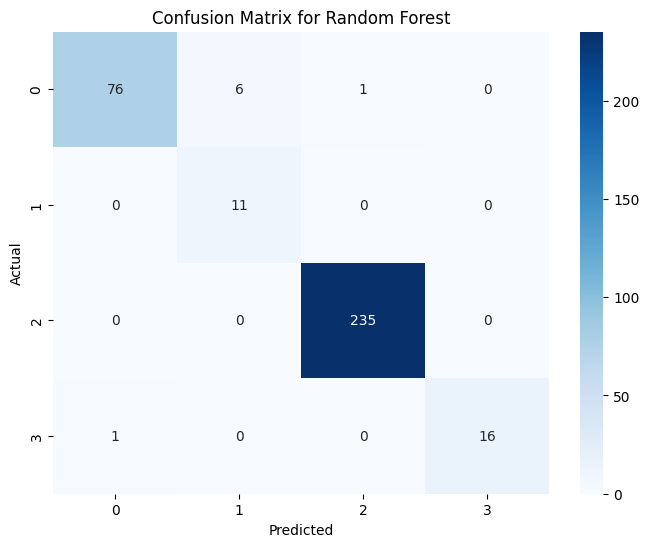

Model: SVM
Accuracy: 0.976878612716763
Precision: 0.9820050120728763
Recall: 0.976878612716763
F1 Score: 0.9784226335286067

Classification Report:
              precision    recall  f1-score     support
0              0.974684  0.927711  0.950617   83.000000
1              0.625000  0.909091  0.740741   11.000000
2              1.000000  1.000000  1.000000  235.000000
3              1.000000  0.941176  0.969697   17.000000
accuracy       0.976879  0.976879  0.976879    0.976879
macro avg      0.899921  0.944495  0.915264  346.000000
weighted avg   0.982005  0.976879  0.978423  346.000000




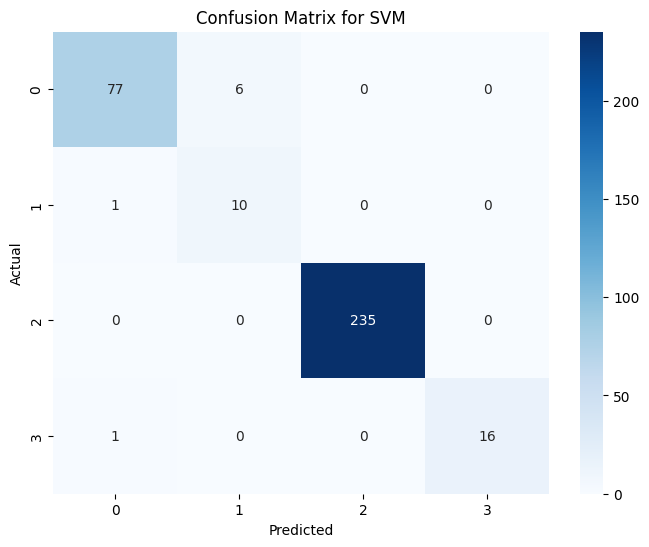

Model: Extra Trees
Accuracy: 0.9710982658959537
Precision: 0.9805253016935401
Recall: 0.9710982658959537
F1 Score: 0.9734494280627302

Classification Report:
              precision    recall  f1-score     support
0              0.986667  0.891566  0.936709   83.000000
1              0.578947  1.000000  0.733333   11.000000
2              1.000000  1.000000  1.000000  235.000000
3              0.941176  0.941176  0.941176   17.000000
accuracy       0.971098  0.971098  0.971098    0.971098
macro avg      0.876698  0.958186  0.902805  346.000000
weighted avg   0.980525  0.971098  0.973449  346.000000




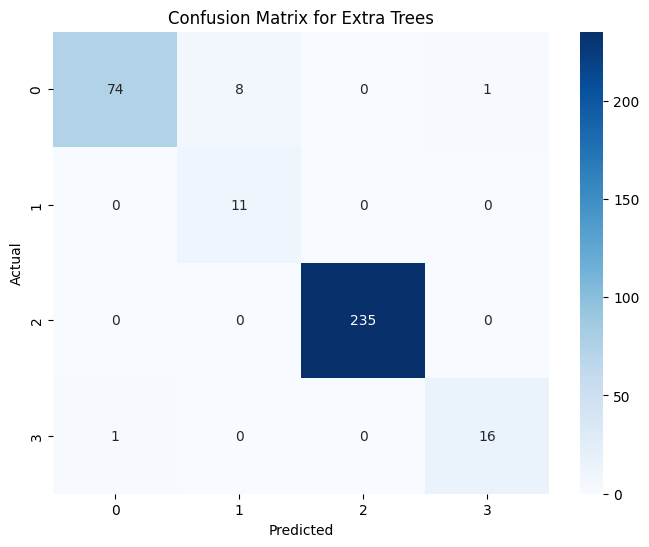

Model: Gradient Boosting
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0     83.0
1                   1.0     1.0       1.0     11.0
2                   1.0     1.0       1.0    235.0
3                   1.0     1.0       1.0     17.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    346.0
weighted avg        1.0     1.0       1.0    346.0




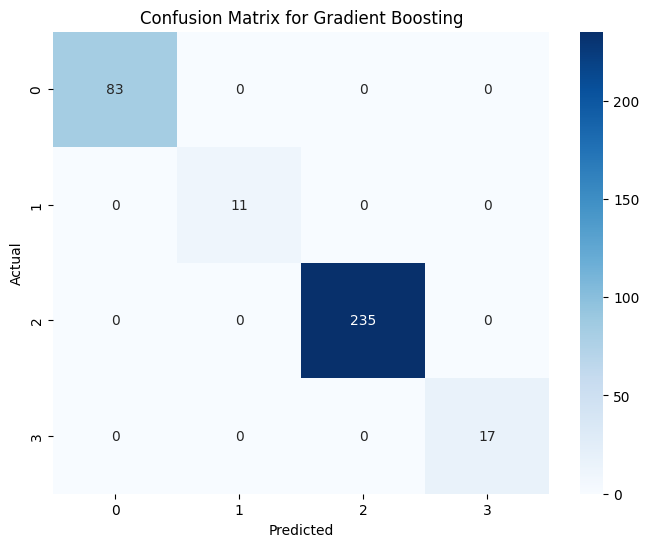

Model: Voting Classifier
Accuracy: 0.9971098265895953
Precision: 0.9971442334159097
Recall: 0.9971098265895953
F1 Score: 0.9970746892971808

Classification Report:
              precision    recall  f1-score    support
0              0.988095  1.000000  0.994012   83.00000
1              1.000000  1.000000  1.000000   11.00000
2              1.000000  1.000000  1.000000  235.00000
3              1.000000  0.941176  0.969697   17.00000
accuracy       0.997110  0.997110  0.997110    0.99711
macro avg      0.997024  0.985294  0.990927  346.00000
weighted avg   0.997144  0.997110  0.997075  346.00000




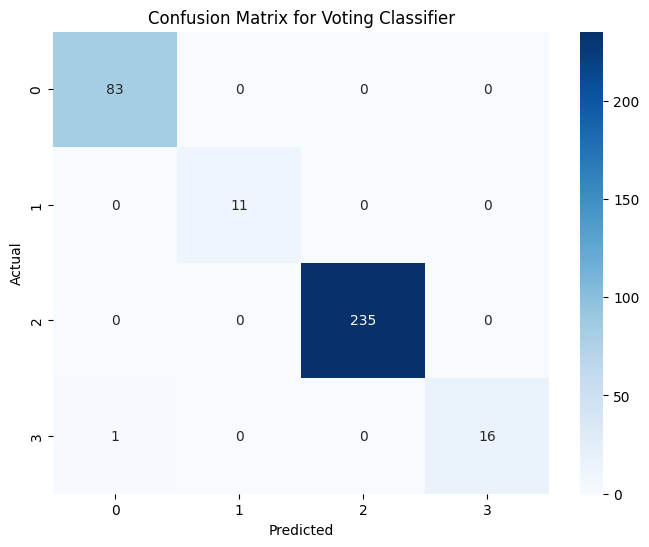

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: AdaBoost Classifier
Accuracy: 0.838150289017341
Precision: 0.8506085200268003
Recall: 0.838150289017341
F1 Score: 0.8380629405978143

Classification Report:
              precision    recall  f1-score    support
0              0.721311  0.530120  0.611111   83.00000
1              0.304348  0.636364  0.411765   11.00000
2              0.933054  0.948936  0.940928  235.00000
3              0.695652  0.941176  0.800000   17.00000
accuracy       0.838150  0.838150  0.838150    0.83815
macro avg      0.663591  0.764149  0.690951  346.00000
weighted avg   0.850609  0.838150  0.838063  346.00000




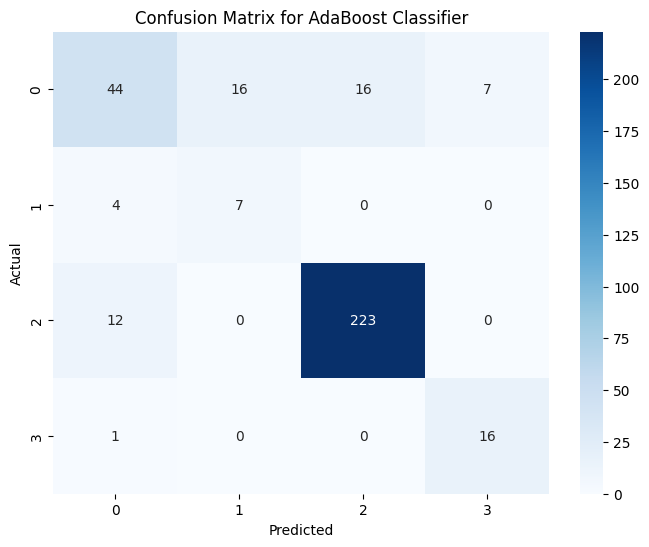

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Model: Bagging Classifier
Accuracy: 0.9739884393063584
Precision: 0.9834985519500276
Recall: 0.9739884393063584
F1 Score: 0.9764571290944122

Classification Report:
              precision    recall  f1-score     support
0              0.987013  0.915663  0.950000   83.000000
1              0.578947  1.000000  0.733333   11.000000
2              1.000000  1.000000  1.000000  235.000000
3              1.000000  0.882353  0.937500   17.000000
accuracy       0.973988  0.973988  0.973988    0.973988
macro avg      0.891490  0.949504  0.905208  346.000000
weighted avg   0.983499  0.973988  0.976457  346.000000




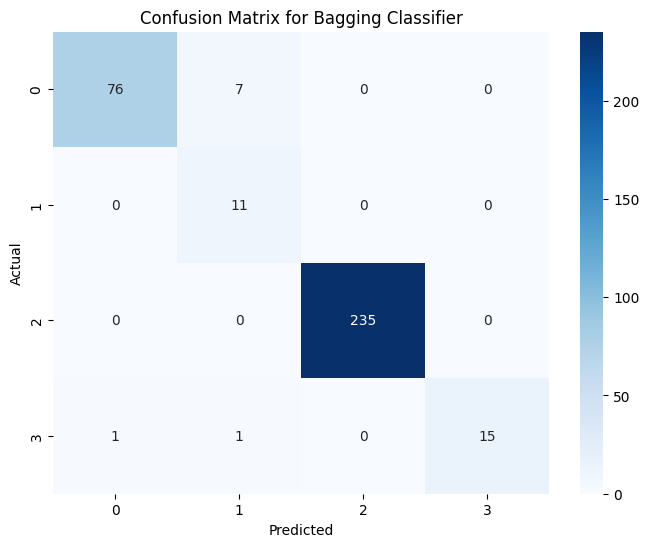

Model: Stacking Classifier
Accuracy: 0.9971098265895953
Precision: 0.9971442334159097
Recall: 0.9971098265895953
F1 Score: 0.9970746892971808

Classification Report:
              precision    recall  f1-score    support
0              0.988095  1.000000  0.994012   83.00000
1              1.000000  1.000000  1.000000   11.00000
2              1.000000  1.000000  1.000000  235.00000
3              1.000000  0.941176  0.969697   17.00000
accuracy       0.997110  0.997110  0.997110    0.99711
macro avg      0.997024  0.985294  0.990927  346.00000
weighted avg   0.997144  0.997110  0.997075  346.00000




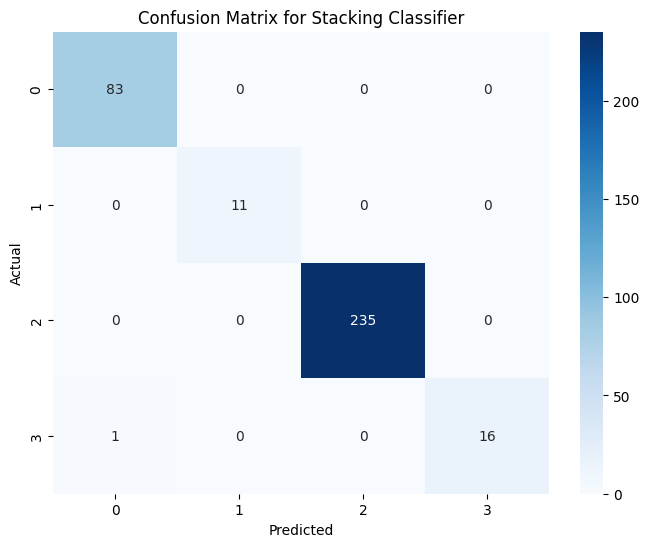

In [162]:
# Section 16: Model Evaluation and Printing Classification Reports
# Evaluate all models including the ensemble techniques
for name, model in best_estimators.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions)
    results.append({'Model': name, 'Accuracy': accuracy})
    classification_reports[name] = classification_report(y_test, predictions, output_dict=True)

    print(f"Model: {name}")
    for metric_name, metric_func in metrics_no_average.items():
        score = metric_func(y_test, predictions)
        print(f"{metric_name}: {score}")
    for metric_name, metric_func in metrics_with_average.items():
        score = metric_func(y_test, predictions, average='weighted')
        print(f"{metric_name}: {score}")
    if len(np.unique(y_test)) == 2:  # Only calculate AUC-ROC for binary classification
        score = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])
        print("AUC-ROC:", score)

    # Print Classification Report
    report_df = pd.DataFrame(classification_reports[name]).transpose()
    print("\nClassification Report:")
    print(report_df)
    print("\n")

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

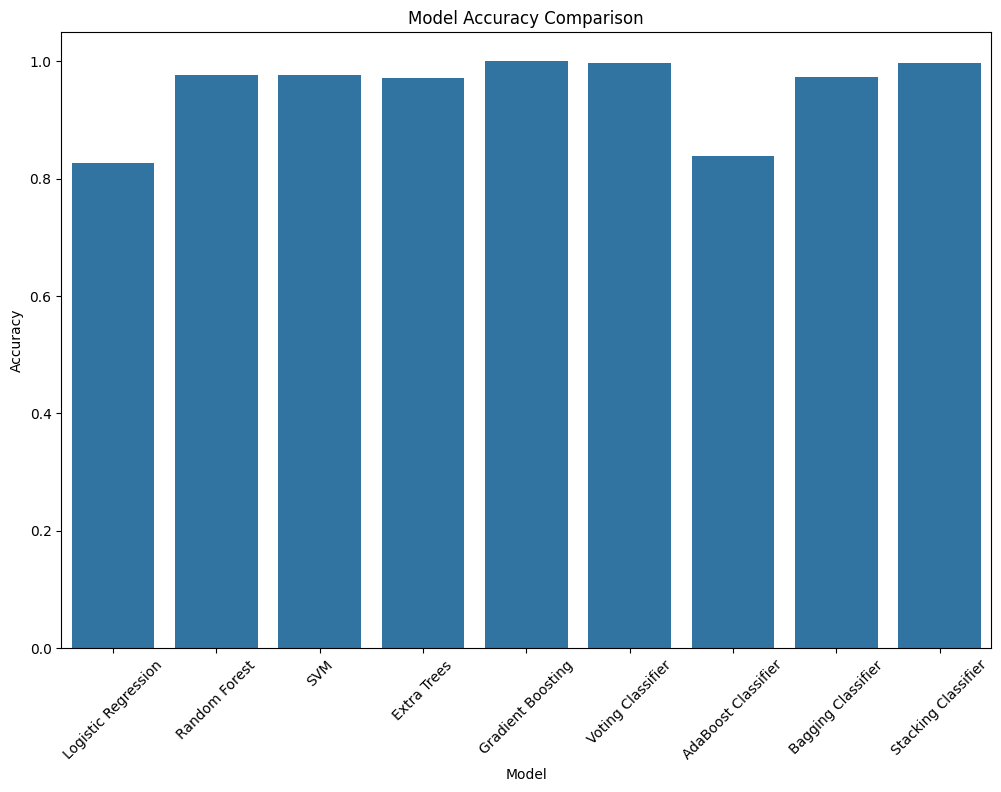

In [163]:
# Section 17: Plot Model Accuracy Comparison
# Plotting accuracy results
results_df = pd.DataFrame(results)
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

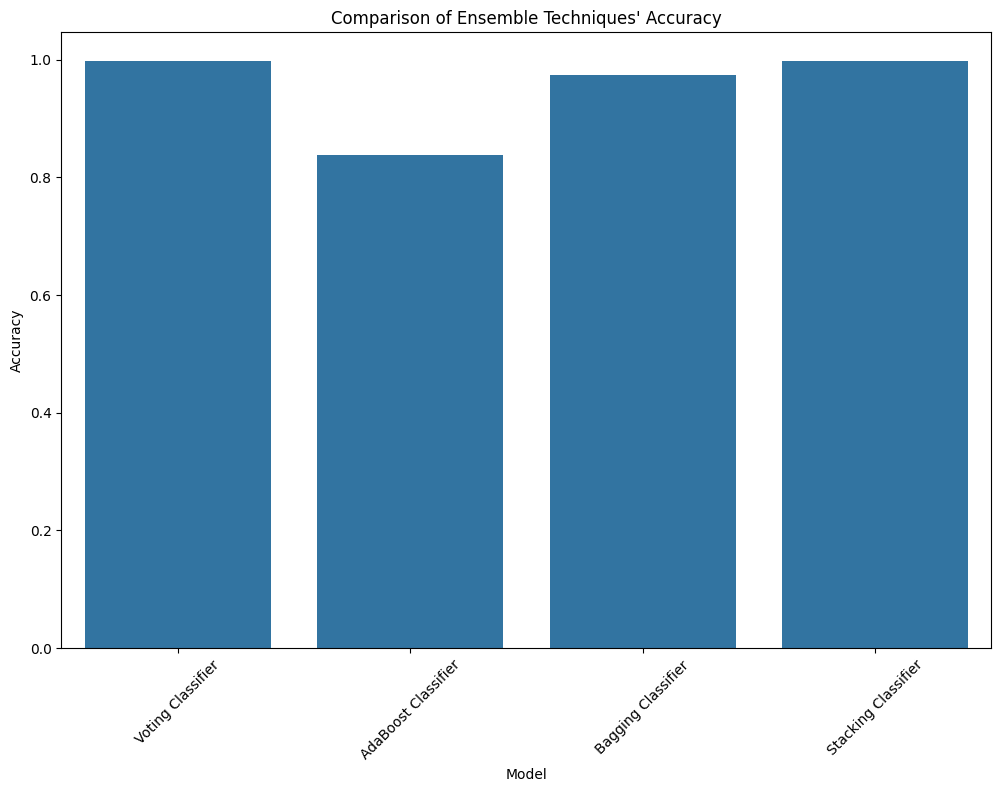

In [164]:
# Section 18: Plot Comparison of Ensemble Techniques' Accuracy

# Extract accuracy results for ensemble techniques
ensemble_results = [result for result in results if result['Model'] in ['Voting Classifier', 'AdaBoost Classifier', 'Bagging Classifier', 'Stacking Classifier']]

# Convert to DataFrame for easier plotting
ensemble_results_df = pd.DataFrame(ensemble_results)

# Plotting accuracy results for ensemble techniques
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Accuracy', data=ensemble_results_df)
plt.title('Comparison of Ensemble Techniques\' Accuracy')
plt.xticks(rotation=45)
plt.show()
